<a href="https://colab.research.google.com/github/pranay8297/deep-learning-projects/blob/master/prisma_own.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "torch==1.4" "torchvision==0.5.0" #use the old version

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 38.9MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [2]:
!pip install ipdb
from ipdb import set_trace as st 

  Created wheel for ipdb: filename=ipdb-0.13.4-cp36-none-any.whl size=10973 sha256=f490ee9e9ee7ac2aa78158e87fb58a75585213cedf589afbfce5f4fca861da50
  Stored in directory: /root/.cache/pip/wheels/56/51/e4/c91c61e3481a1a967beb18c4ea7a2b138a63cce94170b2e206
Successfully built ipdb


In [3]:
!git clone https://github.com/Shashi456/Neural-Style.git
!ls

Cloning into 'Neural-Style'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 199 (delta 2), reused 0 (delta 0), pack-reused 193
Receiving objects: 100% (199/199), 5.14 MiB | 33.49 MiB/s, done.
Resolving deltas: 100% (77/77), done.
Neural-Style  sample_data


In [4]:
from fastai import *
from fastai.vision import *

In [5]:
from PIL import Image as Im

In [6]:
!pwd

/content


In [6]:
path = Path('/content/Neural-Style')
path.ls()

[PosixPath('/content/Neural-Style/Neural Style Transfer'),
 PosixPath('/content/Neural-Style/README.md'),
 PosixPath('/content/Neural-Style/.git'),
 PosixPath('/content/Neural-Style/LICENSE'),
 PosixPath('/content/Neural-Style/Fast Style Transfer')]

In [7]:
path = path/'Neural Style Transfer'
path.ls()

[PosixPath('/content/Neural-Style/Neural Style Transfer/examples'),
 PosixPath('/content/Neural-Style/Neural Style Transfer/README.md'),
 PosixPath('/content/Neural-Style/Neural Style Transfer/train_Pytorch.py'),
 PosixPath('/content/Neural-Style/Neural Style Transfer/train_TensorFlow.py')]

In [8]:
path_exp = path/'examples'
path_exp.ls()
ps = path_exp/'styles'
pc = path_exp/'content'
ps.ls(), pc.ls()

([PosixPath('/content/Neural-Style/Neural Style Transfer/examples/styles/picasso.jpg'),
  PosixPath('/content/Neural-Style/Neural Style Transfer/examples/styles/QiBashi.jpg')],
 [PosixPath('/content/Neural-Style/Neural Style Transfer/examples/content/dancing.jpg')])

In [59]:
stylep = ps.ls()[0]
contentp = pc.ls()[0]
stylep, contentp

(PosixPath('/content/Neural-Style/Neural Style Transfer/examples/styles/picasso.jpg'),
 PosixPath('/content/Neural-Style/Neural Style Transfer/examples/content/dancing.jpg'))

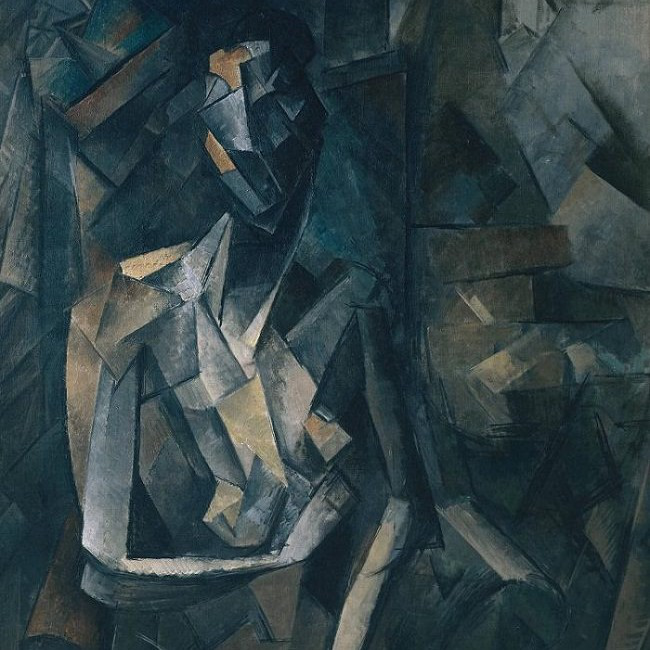

In [60]:
style = open_image(stylep)
content = open_image(contentp)
style

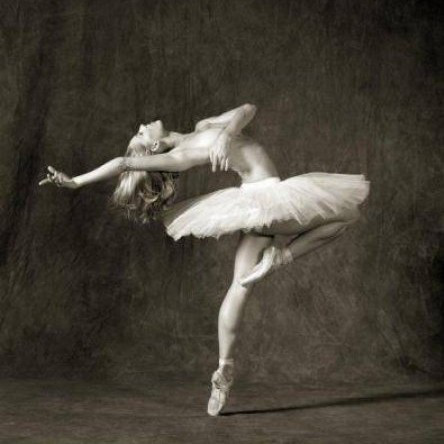

In [61]:
content 

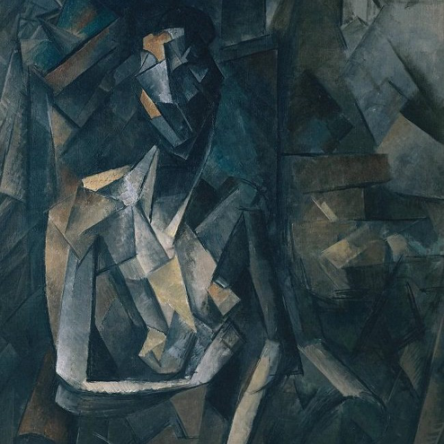

In [62]:
#test
c, s = Im.open(contentp), Im.open(stylep)
c.size, s.size
temp = s.resize(c.size, resample = 2)
temp

In [63]:
def resize_data(dest):
  #1 resize the style to conetnt image
  dest.mkdir(exist_ok = True, parents = True)
  c, s = Im.open(contentp).convert('RGB'), Im.open(stylep).convert('RGB')
  s = s.resize(c.size, resample= 2)
  c.save(dest/contentp.name)
  s.save(dest/stylep.name)
  return dest/contentp.name, dest/stylep.name

In [64]:
dest = Path('/content/Neural-Style/Neural Style Transfer/examples/transformed')
cpath, spath = resize_data(dest)

In [65]:
content = open_image(cpath)  
style = open_image(spath)
content, style 

(Image (3, 444, 444), Image (3, 444, 444))

In [66]:
dc = content.data
ds = style.data 

In [16]:
x = dc.clone()
x.requires_grad = True

In [19]:
class Hook():
  def __init__(self, module):
    self.module = module
    self.stored = None
    self.hook = self.module.register_forward_hook(self.hook_fn)
  
  def hook_fn(self, module, input, output):
    self.stored = output
  
  def remove_hook():
    self.hook.remove()
    self.stored = None

In [20]:
from torchvision.models import vgg16_bn
vgg = vgg16_bn(pretrained = True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [67]:
ds, dc = ds.cuda(), dc.cuda()
ds.requires_grad = False
dc.requires_grad = False
gen = dc.clone()
gen.requires_grad = True
# ds, dc, gen
ds.shape, dc.shape, gen.shape
ds, dc, gen = ds[None], dc[None], gen[None]
ds.shape, dc.shape, gen.shape

(torch.Size([1, 3, 444, 444]),
 torch.Size([1, 3, 444, 444]),
 torch.Size([1, 3, 444, 444]))

In [22]:
layers = vgg.features.eval().cuda()
layer_ids = []
for idx, mod in enumerate(layers):
  if isinstance(mod, torch.nn.modules.pooling.MaxPool2d):
    layer_ids.append(idx - 1)
layer_ids

[5, 12, 22, 32, 42]

In [23]:
base_loss = F.l1_loss
base_loss

<function torch.nn.functional.l1_loss>

In [25]:
class ContentLoss(nn.Module):

  def __init__(self, base_loss, layer_wgts = [4., 10., 12., 10., 7.], layer_ids = [5, 12, 22, 32, 42], content_img = dc):
    super().__init__()

    #this loss fn should have to have two things ---  default should have all acts for default content img and calculate gen image acts dynamically and response
    self.base_loss = base_loss
    self.layer_wgts = layer_wgts
    self.layer_ids = layer_ids
    self.base_model = layers
    self.hooks = [Hook(layers[i]) for i in self.layer_ids]
    self.content = content_img
    self.content.cuda()
    self.acts_y = [i*j for i, j in zip(self.layer_wgts, self.get_stored(self.content))]
  
  def get_stored(self, inp):
    
    self.base_model(inp)
    return [i.stored for i in self.hooks]
  
  def forward(self, gen):

    acts_yhat = [i*j for i, j in zip(self.layer_wgts, self.get_stored(gen))]
    losses = [self.base_loss(i, j) for i, j in zip(acts_yhat, self.acts_y)]
    return sum(losses)

In [24]:
#test
closs = ContentLoss(base_loss = base_loss)

In [25]:
#test
closs(gen)

tensor(0., device='cuda:0', grad_fn=<AddBackward0>)

In [23]:
class StyleLoss(nn.Module):

  def __init__(self, base_loss, layer_wgts = [4., 3., 2., 10., 12.], layer_ids = [5, 12, 22, 32, 42], style_img = ds):
    super().__init__()

    self.base_loss = base_loss
    self.layer_wgts = layer_wgts
    self.layer_ids = layer_ids
    self.base_model = layers
    self.hooks = [Hook(layers[i]) for i in self.layer_ids]
    self.style = style_img
    self.style.cuda()
    self.acts_y = [self.gram_matrix(j)*i for i, j in zip(self.layer_wgts, self.get_stored(self.style))]
  
  def get_stored(self, input):
    self.base_model(input)
    return [i.stored for i in self.hooks]
  
  def gram_matrix(self, acts):
    bs, c, h, w = acts.shape
    temp = acts.view(bs, c, w*h)
    return (temp @ temp.transpose(1, 2))/(h*w)

  def forward(self, gen):

    op = self.get_stored(gen)
    losses = [self.base_loss(wgt * self.gram_matrix(generated), st) for wgt, generated, st in zip(self.layer_wgts, op, self.acts_y)]
    return sum(losses)


In [26]:
#test
sloss = StyleLoss(base_loss)

In [107]:
# test
sloss(gen)

tensor(0.0182, device='cuda:0', grad_fn=<AddBackward0>)

In [24]:
class Loss(nn.Module):
  def __init__(self, base_loss, c_layer_wgts = [4., 10., 12., 10., 7.], s_layer_wgts = [4., 7., 10., 15., 12.], layer_ids = [5, 12, 22, 32, 42], style_img = ds, content_img = dc):
    super().__init__()

    self.style_loss_func = StyleLoss(base_loss, layer_wgts = s_layer_wgts)
    self.content_loss_func = ContentLoss(base_loss, layer_wgts = c_layer_wgts)

    self.cw, self.sw = 20, 100
  
  def forward(self, gen):

    return self.cw * self.content_loss_func(gen) + self.sw * self.style_loss_func(gen)

In [140]:
class MainLoss(nn.Module):
  def __init__(self, base_loss = base_loss, clayer_wgts = [4., 10., 8., 0., 0.], slayer_wgts = [4., 7., 12., 14., 10.], layer_ids = [5, 12, 22, 32, 42], content_img = dc, style_img = ds):

    super().__init__()

    self.base_loss = base_loss
    self.base_model = layers
    self.layer_ids = layer_ids
    self.c_wgts = clayer_wgts
    self.s_wgts = slayer_wgts

    self.hooks = [Hook(self.base_model[i]) for i in self.layer_ids]

    self.content = content_img.cuda()
    self.style = style_img.cuda()

    #calculate content acts
    self.acts_content = self.calculate_acts(self.content)#[i*j for i, j in zip(self.c_wgts, self.get_stored(self.content))]
    
    #calculate gram acts
    self.acts_style = self.calculate_acts(self.style, is_style = True) #[i*self.gram(j) for i, j in zip(self.s_wgts, self.get_stored(self.style))]
    self.sw, self.cw = 200., 5.

  def get_stored(self, input):
    self.base_model(input)
    return [i.stored for i in self.hooks]
  
  def gram(self, acts):
    bs, c, h, w = acts.shape
    temp = acts.view(bs, c, h*w)
    return (temp @ temp.transpose(1, 2))/h*w
  
  def calculate_acts(self, input, is_style = False):
    if not is_style:
      return [i*j for i, j in zip(self.c_wgts, self.get_stored(input))]
    return [i*self.gram(j) for i, j in zip(self.s_wgts, self.get_stored(input))]
  
  def forward(self, input):

    c_yhat = self.calculate_acts(input)
    s_yhat = self.calculate_acts(input, is_style = True)

    losses = [self.cw*self.base_loss(i, j) for i, j in zip(c_yhat, self.acts_content)] 
    losses += [self.sw*self.base_loss(i, j) for i, j in zip(s_yhat, self.acts_style)]

    return sum(losses)

In [141]:
from torch.autograd import Variable
gen = Variable(dc.clone(), requires_grad=True)

In [142]:
#test
print(torch.max(dc), torch.max(ds), torch.max(gen)) 
print(torch.min(dc), torch.min(ds), torch.min(gen))

tensor(2.6400, device='cuda:0') tensor(1.9080, device='cuda:0') tensor(2.6400, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-2.1008, device='cuda:0') tensor(-2.1179, device='cuda:0') tensor(-2.1008, device='cuda:0', grad_fn=<MinBackward1>)


In [68]:
def normalize_batch(batch):
    # normalize using imagenet mean and std
    mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    # batch = batch.div_(255.0)
    return (batch - mean) / std
dc = normalize_batch(dc)
ds = normalize_batch(ds)
gen = normalize_batch(gen)

In [69]:
print(torch.max(dc), torch.max(ds), torch.max(gen)) 
print(torch.min(dc), torch.min(ds), torch.min(gen))

tensor(2.6400, device='cuda:0') tensor(1.9080, device='cuda:0') tensor(2.6400, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-2.1008, device='cuda:0') tensor(-2.1179, device='cuda:0') tensor(-2.1008, device='cuda:0', grad_fn=<MinBackward1>)


In [70]:
def denorm(batch):
  mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
  std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
  return batch * std + mean

In [72]:
dc.shape, ds.shape, gen.shape

(torch.Size([1, 3, 444, 444]),
 torch.Size([1, 3, 444, 444]),
 torch.Size([1, 3, 444, 444]))

In [143]:
loss_func = MainLoss(base_loss)

In [144]:
class MyBlock(nn.Module):
  def __init__(self, gen):
    super().__init__()
    gen.requires_grad = True
    self.gen = nn.Parameter(gen)

In [145]:
generated = MyBlock(dc.clone()).cuda()
for i in generated.parameters():
  print(i.shape)

torch.Size([1, 3, 444, 444])


In [146]:
optimizer = optim.LBFGS(generated.parameters())

In [107]:
def update(lr, epcs = 3):
  losses = []
  st()
  for i in range(epcs):
    loss = loss_func(gen.gen)
    loss.backward(retain_graph = True)
    with torch.no_grad():
      for param in gen.parameters():
        param.sub_(lr * param.grad)
        param.grad.zero_()
    losses.append(loss.item())
    print(losses)
  return losses

In [147]:
def update_new(lr = 1e-03, epcs = 10):
  losses = []
  for i in range(epcs):
    cyc_loss = []
    def cl():
      optimizer.zero_grad()
      loss = loss_func(generated.gen)
      loss.backward(retain_graph = True)
      cyc_loss.append(loss.item())
      return loss

    optimizer.step(cl)
    losses.append(sum(cyc_loss)/len(cyc_loss))
    print(losses[-1])

In [148]:
update_new(1e-07, 50)

538572.990625
82396.84375
58064.0853515625
46013.0607421875
39324.1833984375
34924.30078125
31162.5345703125
27919.69677734375
25221.473046875
23023.61171875
21144.34619140625
19591.93857421875
18333.93427734375
17262.77255859375
16273.0966796875
15413.36796875
14683.391064453124
14006.256005859375
13432.7623046875
12919.6296875
12478.337646484375
12066.653369140626
11680.812890625
11325.126513671876
10995.599951171875
10676.840869140626
10365.531689453124
10072.10126953125
9806.835009765626
9546.20205078125
9298.751025390626
9082.41181640625
8876.401171875
8674.253076171875
8306.73876953125
8124.4431640625
7944.3501953125
7768.855786132813
7606.181811523437
7453.296655273438
7311.878955078125
7169.684741210937
7027.007421875
6893.19658203125
6762.04365234375
6633.38828125
6512.963061523437
6388.428540039063
6274.682177734375


In [109]:
res = generated.gen.data
torch.min(res[0]), torch.max(res[0])

(tensor(-2.3342, device='cuda:0'), tensor(2.2321, device='cuda:0'))

In [103]:
# torch.min(res[0]), torch.max(res[0])
torch.min(res[0]), torch.max(res[0])

(tensor(-2.3851, device='cuda:0'), tensor(2.1893, device='cuda:0'))

In [113]:
nres = res[0].clone()
nres = denorm(nres)
nres -= nres.min(1, keepdim=True)[0]
nres /= nres.max(1, keepdim=True)[0]
torch.min(nres), torch.max(nres)

(tensor(0., device='cuda:0'), tensor(1., device='cuda:0'))

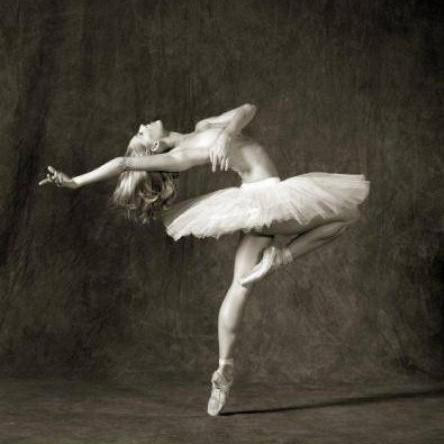

In [111]:
content

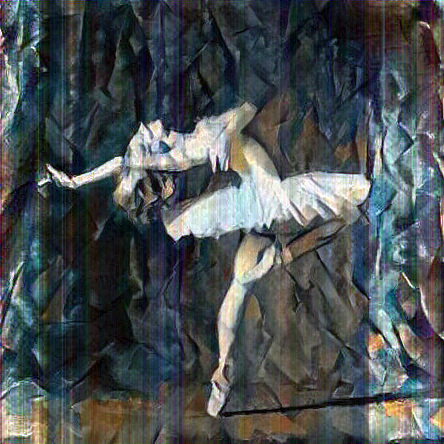

In [114]:
Image(nres)